In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers
from keras.layers import LSTM
from keras.regularizers import L1L2
import pandas as pd
import numpy as np


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
plt.rcParams["figure.figsize"] = (16,4)

Using TensorFlow backend.


In [2]:
raw = pd.read_csv('../../experiment/1624714294_feature_v0.1.3.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 16 columns):
DT                    371 non-null object
COMP_PRD_NO           371 non-null int64
COMP_STOCK_NO         371 non-null int64
BASE_QTY              371 non-null int64
INCM_QTY              371 non-null int64
END_QTY               371 non-null int64
ORD_CNT               371 non-null int64
ORD_QTY               371 non-null int64
MIN_ACTUAL_PAY        371 non-null int64
MED_ACTUAL_PAY        371 non-null int64
EVNT_11ST_2016        371 non-null object
EVNT_MW_HOT_ISSUE     371 non-null object
EVNT_MW_SHCK_DEAL     371 non-null object
EVNT_MW_LOWER_BANS    371 non-null object
EVNT_NOW_BANS         371 non-null object
EVNT_OTHERS           371 non-null object
dtypes: int64(9), object(7)
memory usage: 46.5+ KB


In [3]:
raw.head(2)

,DT,COMP_PRD_NO,COMP_STOCK_NO,BASE_QTY,INCM_QTY,END_QTY,ORD_CNT,ORD_QTY,MIN_ACTUAL_PAY,MED_ACTUAL_PAY,EVNT_11ST_2016,EVNT_MW_HOT_ISSUE,EVNT_MW_SHCK_DEAL,EVNT_MW_LOWER_BANS,EVNT_NOW_BANS,EVNT_OTHERS
0,2016-11-17,1624714294,6252686295,0,1024,1018,14,32,15840,17853,N,N,N,N,N,N
1,2016-11-18,1624714294,6252686295,1018,640,254,785,1592,12465,14685,N,N,Y,N,N,N


In [4]:
raw.tail(2)

,DT,COMP_PRD_NO,COMP_STOCK_NO,BASE_QTY,INCM_QTY,END_QTY,ORD_CNT,ORD_QTY,MIN_ACTUAL_PAY,MED_ACTUAL_PAY,EVNT_11ST_2016,EVNT_MW_HOT_ISSUE,EVNT_MW_SHCK_DEAL,EVNT_MW_LOWER_BANS,EVNT_NOW_BANS,EVNT_OTHERS
369,2017-11-23,1624714294,6252686295,1276,0,1154,97,127,15880,18400,N,N,N,N,N,N
370,2017-11-25,1624714294,6252686295,1688,0,1688,60,79,16710,18400,N,N,N,N,N,Y


In [5]:
dataset = raw.copy()
dataset.drop_duplicates(inplace=True)

In [6]:
target = dataset['ORD_QTY']
dataset['DT'] = pd.to_datetime(dataset['DT'])
dataset['week'] = dataset['DT'].dt.weekday_name
dataset['year'] = dataset['DT'].dt.year.apply(lambda x: 'year_'+str(x))
dataset['month'] = dataset['DT'].dt.month.apply(lambda x: 'month_'+str(x))
dataset['day'] = dataset['DT'].dt.day.apply(lambda x: 'day_'+str(x))
dataset.set_index('DT',inplace=True)
dataset.sort_index(inplace=True)

dataset.loc[:,'EVNT_11ST_2016'] = dataset['EVNT_11ST_2016'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_MW_HOT_ISSUE'] = dataset['EVNT_MW_HOT_ISSUE'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_MW_SHCK_DEAL'] = dataset['EVNT_MW_SHCK_DEAL'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_MW_LOWER_BANS'] = dataset['EVNT_MW_LOWER_BANS'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_NOW_BANS'] = dataset['EVNT_NOW_BANS'].apply(lambda x: 1 if x=='Y'else 0)
dataset.loc[:,'EVNT_OTHERS'] = dataset['EVNT_OTHERS'].apply(lambda x: 1 if x=='Y'else 0)

dataset = pd.concat([dataset, pd.get_dummies(dataset['week'])],axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['year'])],axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['month'])],axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['day'])],axis=1)
dataset['target'] = dataset['ORD_QTY']
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 2016-11-17 to 2017-11-27
Data columns (total 72 columns):
COMP_PRD_NO           371 non-null int64
COMP_STOCK_NO         371 non-null int64
BASE_QTY              371 non-null int64
INCM_QTY              371 non-null int64
END_QTY               371 non-null int64
ORD_CNT               371 non-null int64
ORD_QTY               371 non-null int64
MIN_ACTUAL_PAY        371 non-null int64
MED_ACTUAL_PAY        371 non-null int64
EVNT_11ST_2016        371 non-null int64
EVNT_MW_HOT_ISSUE     371 non-null int64
EVNT_MW_SHCK_DEAL     371 non-null int64
EVNT_MW_LOWER_BANS    371 non-null int64
EVNT_NOW_BANS         371 non-null int64
EVNT_OTHERS           371 non-null int64
week                  371 non-null object
year                  371 non-null object
month                 371 non-null object
day                   371 non-null object
Friday                371 non-null uint8
Monday                371 non-null uint8
Saturday   

In [7]:
dataset.drop(['COMP_PRD_NO','COMP_STOCK_NO','ORD_CNT','ORD_QTY','week','year','month','day'],axis=1,inplace=True)

In [8]:
target = ['target']

main_feature = dataset.drop(['MIN_ACTUAL_PAY', 'MED_ACTUAL_PAY', 'EVNT_11ST_2016',
       'EVNT_MW_HOT_ISSUE', 'EVNT_MW_SHCK_DEAL', 'EVNT_MW_LOWER_BANS',
       'EVNT_NOW_BANS', 'EVNT_OTHERS','target'],axis=1).columns.tolist()
aux_feature = dataset.columns.drop(target+main_feature)

In [9]:
aux_feature

Index(['MIN_ACTUAL_PAY', 'MED_ACTUAL_PAY', 'EVNT_11ST_2016',
       'EVNT_MW_HOT_ISSUE', 'EVNT_MW_SHCK_DEAL', 'EVNT_MW_LOWER_BANS',
       'EVNT_NOW_BANS', 'EVNT_OTHERS'],
      dtype='object')

In [10]:
data = dataset.copy()
in_seq = 14
out_seq = 14
batch_size = 10

In [11]:
feature_df = data[main_feature]
target_df = data[target]
aux_df = data[aux_feature]

feature_df = feature_df.astype('float32')
target_df = target_df.astype('float32')
aux_df = aux_df.astype('float32')

main_feature_len = len(main_feature)+len(target)

In [12]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0,1))
aux_scaler = MinMaxScaler(feature_range=(0,1))
    
feature_df.loc[:,:] = feature_scaler.fit_transform(feature_df)
target_df.loc[:,:] = target_scaler.fit_transform(target_df)
aux_df.loc[:,:] = aux_scaler.fit_transform(aux_df)

preprocessed_df = pd.concat([feature_df,target_df],axis=1)

In [13]:
preprocessed_df.head(2)

,BASE_QTY,INCM_QTY,END_QTY,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,target
DT,,,,,,,,,,,,,,,,,,,,,
2016-11-17,0.000000,0.32,0.146190,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019485
2016-11-18,0.147301,0.20,0.035497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [14]:
cols = list()
names = list()
for i in range(in_seq, 0, -1):
    cols.append(preprocessed_df.shift(i))
    names += [(feature_name+'(t-%d)' % i) for feature_name in preprocessed_df.columns]

In [15]:
temp_cols = list()
temp_names = list()
for i in range(out_seq):
    temp_cols.append(preprocessed_df[['target']].shift(-i))
    temp_names += [('t+%d' % i) for feature_name in preprocessed_df[['target']].columns]
    
aux_temp_cols = list()
aux_temp_names = list()
for i in range(out_seq):
    aux_temp_cols.append(aux_df.shift(-i))
    
    aux_temp_names += [feature_name+('(t+%d)' % i) for feature_name in aux_df.columns]

In [16]:
temp_df = pd.concat(temp_cols,axis=1)
temp_df.columns = temp_names
temp_df.dropna(inplace=True)

aux_temp_df = pd.concat(aux_temp_cols,axis=1)
aux_temp_df.columns = aux_temp_names
aux_df.dropna(inplace=True)

In [17]:
time_series_data = pd.concat(cols,axis=1)
time_series_data.columns = names
time_series_data.head(2)

,BASE_QTY(t-14),INCM_QTY(t-14),END_QTY(t-14),Friday(t-14),Monday(t-14),Saturday(t-14),Sunday(t-14),Thursday(t-14),Tuesday(t-14),Wednesday(t-14),...,day_3(t-1),day_30(t-1),day_31(t-1),day_4(t-1),day_5(t-1),day_6(t-1),day_7(t-1),day_8(t-1),day_9(t-1),target(t-1)
DT,,,,,,,,,,,,,,,,,,,,,
2016-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019485


In [18]:
time_series_data = pd.concat([time_series_data,temp_df],axis=1) 
time_series_data.dropna(inplace=True)
print(time_series_data.head(2))

            BASE_QTY(t-14)  INCM_QTY(t-14)  END_QTY(t-14)  Friday(t-14)  \
DT                                                                        
2016-12-05        0.000000            0.32       0.146190           0.0   
2016-12-06        0.147301            0.20       0.035497           1.0   

            Monday(t-14)  Saturday(t-14)  Sunday(t-14)  Thursday(t-14)  \
DT                                                                       
2016-12-05           0.0             0.0           0.0             1.0   
2016-12-06           0.0             0.0           0.0             0.0   

            Tuesday(t-14)  Wednesday(t-14)    ...          t+4       t+5  \
DT                                            ...                          
2016-12-05            0.0              0.0    ...     0.160277  0.135135   
2016-12-06            0.0              0.0    ...     0.135135  0.362665   

                 t+6       t+7       t+8       t+9      t+10      t+11  \
DT                     

In [19]:
time_series_data.index

DatetimeIndex(['2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14',
               ...
               '2017-11-04', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14'],
              dtype='datetime64[ns]', name='DT', length=344, freq=None)

In [20]:
train_size = int(len(time_series_data)/batch_size)*batch_size
test_size = batch_size*3

In [21]:
time_series_data = time_series_data.tail(train_size)

In [22]:
train_df = time_series_data.iloc[:-test_size]
test_df = time_series_data.iloc[-test_size:]

In [23]:
train_df.index

DatetimeIndex(['2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
               '2016-12-17', '2016-12-18',
               ...
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10', '2017-10-11', '2017-10-12',
               '2017-10-13', '2017-10-14'],
              dtype='datetime64[ns]', name='DT', length=310, freq=None)

In [24]:
test_df.index

DatetimeIndex(['2017-10-15', '2017-10-16', '2017-10-17', '2017-10-18',
               '2017-10-19', '2017-10-20', '2017-10-21', '2017-10-22',
               '2017-10-23', '2017-10-24', '2017-10-25', '2017-10-26',
               '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
               '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03',
               '2017-11-04', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14'],
              dtype='datetime64[ns]', name='DT', freq=None)

### aux_feature add

In [25]:
aux_df = pd.concat([aux_df,aux_temp_df],axis=1) 
aux_df.dropna(inplace=True)
print(aux_df.head(2))

            MIN_ACTUAL_PAY  MED_ACTUAL_PAY  EVNT_11ST_2016  EVNT_MW_HOT_ISSUE  \
DT                                                                              
2016-11-17        0.578578        0.533166             0.0                0.0   
2016-11-18        0.282265        0.002513             0.0                0.0   

            EVNT_MW_SHCK_DEAL  EVNT_MW_LOWER_BANS  EVNT_NOW_BANS  EVNT_OTHERS  \
DT                                                                              
2016-11-17                0.0                 0.0            0.0          0.0   
2016-11-18                1.0                 0.0            0.0          0.0   

            MIN_ACTUAL_PAY(t+0)  MED_ACTUAL_PAY(t+0)        ...          \
DT                                                          ...           
2016-11-17             0.578578             0.533166        ...           
2016-11-18             0.282265             0.002513        ...           

            EVNT_NOW_BANS(t+12)  EVNT_OTHERS(t+12

In [26]:
aux_df.index

DatetimeIndex(['2016-11-17', '2016-11-18', '2016-11-21', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30',
               ...
               '2017-11-04', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14'],
              dtype='datetime64[ns]', name='DT', length=358, freq=None)

In [27]:
aux_train_df = aux_df.loc[train_df.index]
aux_test_df = aux_df.loc[test_df.index]

In [28]:
aux_train_X = aux_train_df.values
aux_test_X = aux_test_df.values
print(aux_train_X.shape, aux_test_X.shape)

(310, 120) (30, 120)


In [29]:
train_X, train_y = train_df.values[:,:-out_seq], train_df.values[:,-out_seq:]
train_X, train_y = train_X.reshape(train_X.shape[0],in_seq,main_feature_len), train_y.reshape(train_y.shape[0],out_seq)

In [30]:
print(train_X.shape, train_y.shape)

(310, 14, 56) (310, 14)


In [31]:
test_X, test_y = test_df.values[:,:-out_seq], test_df.values[:,-out_seq:]
test_X, test_y = test_X.reshape(test_X.shape[0],in_seq,main_feature_len), test_y.reshape(test_y.shape[0],out_seq)

In [32]:
print(test_X.shape, test_y.shape)

(30, 14, 56) (30, 14)


In [33]:
import keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

In [34]:
main_input = Input(shape=(train_X.shape[1],train_X.shape[2]),batch_shape=(batch_size,train_X.shape[1],train_X.shape[2]),name='main_input')

#x = LSTM(32,return_sequences=True,dropout=0.3,stateful=True)(main_input)
#x = LSTM(32,return_sequences=True,dropout=0.4,stateful=True)(x)
#lstm_out = x
lstm_out = LSTM(32,dropout=0.3,stateful=True)(main_input)

auxiliary_output = Dense(out_seq,activation='sigmoid',name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(aux_train_X.shape[1],),batch_shape=(batch_size,aux_train_X.shape[1]),name='aux_input')

x = keras.layers.concatenate([lstm_out,auxiliary_input])
x = Dense(120,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)

main_output = Dense(out_seq,activation='sigmoid',name='main_output')(x)

model = Model(inputs=[main_input,auxiliary_input], outputs=[main_output,auxiliary_output])

#optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer='adam', loss='mse',loss_weights=[1.,0.2])

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (10, 14, 56)          0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (10, 32)              11392       main_input[0][0]                 
____________________________________________________________________________________________________
aux_input (InputLayer)           (10, 120)             0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (10, 152)             0           lstm_1[0][0]                     
                                                                   aux_input[0][0]         

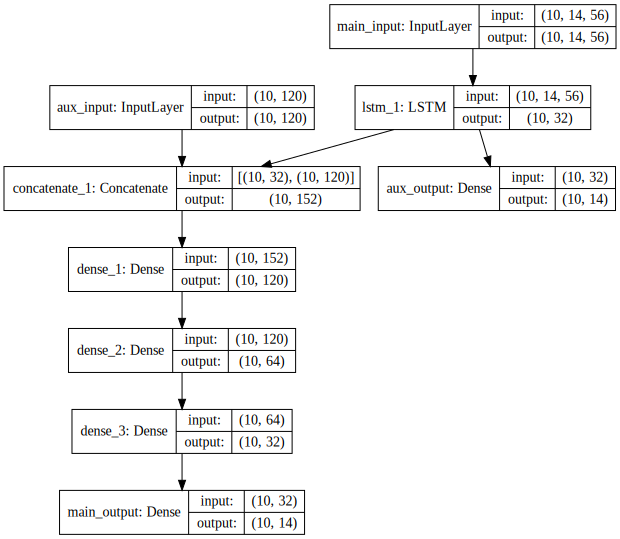

In [36]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [37]:
%%time
history = model.fit([train_X, aux_train_X], [train_y, train_y],epochs=2000, batch_size=batch_size,\
                   validation_data=([test_X,aux_test_X],[test_y,test_y]),verbose=2,shuffle=False)

Train on 310 samples, validate on 30 samples
Epoch 1/2000
1s - loss: 0.1094 - main_output_loss: 0.0807 - aux_output_loss: 0.1435 - val_loss: 0.0303 - val_main_output_loss: 0.0121 - val_aux_output_loss: 0.0909
Epoch 2/2000
0s - loss: 0.0167 - main_output_loss: 0.0082 - aux_output_loss: 0.0424 - val_loss: 0.0149 - val_main_output_loss: 0.0110 - val_aux_output_loss: 0.0199
Epoch 3/2000
0s - loss: 0.0085 - main_output_loss: 0.0068 - aux_output_loss: 0.0087 - val_loss: 0.0114 - val_main_output_loss: 0.0096 - val_aux_output_loss: 0.0093
Epoch 4/2000
0s - loss: 0.0072 - main_output_loss: 0.0061 - aux_output_loss: 0.0054 - val_loss: 0.0111 - val_main_output_loss: 0.0094 - val_aux_output_loss: 0.0085
Epoch 5/2000
0s - loss: 0.0068 - main_output_loss: 0.0057 - aux_output_loss: 0.0052 - val_loss: 0.0106 - val_main_output_loss: 0.0090 - val_aux_output_loss: 0.0083
Epoch 6/2000
0s - loss: 0.0065 - main_output_loss: 0.0055 - aux_output_loss: 0.0051 - val_loss: 0.0104 - val_main_output_loss: 0.0088 -

0s - loss: 0.0033 - main_output_loss: 0.0025 - aux_output_loss: 0.0043 - val_loss: 0.0122 - val_main_output_loss: 0.0105 - val_aux_output_loss: 0.0083
Epoch 52/2000
0s - loss: 0.0035 - main_output_loss: 0.0027 - aux_output_loss: 0.0042 - val_loss: 0.0112 - val_main_output_loss: 0.0095 - val_aux_output_loss: 0.0084
Epoch 53/2000
0s - loss: 0.0036 - main_output_loss: 0.0028 - aux_output_loss: 0.0042 - val_loss: 0.0100 - val_main_output_loss: 0.0084 - val_aux_output_loss: 0.0083
Epoch 54/2000
0s - loss: 0.0038 - main_output_loss: 0.0030 - aux_output_loss: 0.0042 - val_loss: 0.0102 - val_main_output_loss: 0.0086 - val_aux_output_loss: 0.0084
Epoch 55/2000
0s - loss: 0.0036 - main_output_loss: 0.0027 - aux_output_loss: 0.0042 - val_loss: 0.0096 - val_main_output_loss: 0.0079 - val_aux_output_loss: 0.0084
Epoch 56/2000
0s - loss: 0.0035 - main_output_loss: 0.0027 - aux_output_loss: 0.0042 - val_loss: 0.0103 - val_main_output_loss: 0.0086 - val_aux_output_loss: 0.0085
Epoch 57/2000
0s - loss:

0s - loss: 0.0017 - main_output_loss: 0.0010 - aux_output_loss: 0.0034 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0083
Epoch 102/2000
0s - loss: 0.0017 - main_output_loss: 0.0010 - aux_output_loss: 0.0033 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0082
Epoch 103/2000
0s - loss: 0.0017 - main_output_loss: 0.0010 - aux_output_loss: 0.0033 - val_loss: 0.0085 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0083
Epoch 104/2000
0s - loss: 0.0017 - main_output_loss: 0.0011 - aux_output_loss: 0.0033 - val_loss: 0.0089 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0084
Epoch 105/2000
0s - loss: 0.0017 - main_output_loss: 9.9736e-04 - aux_output_loss: 0.0033 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0083
Epoch 106/2000
0s - loss: 0.0016 - main_output_loss: 9.7563e-04 - aux_output_loss: 0.0033 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0084
Epoch 107/2

0s - loss: 0.0022 - main_output_loss: 0.0016 - aux_output_loss: 0.0032 - val_loss: 0.0088 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0079
Epoch 151/2000
0s - loss: 0.0018 - main_output_loss: 0.0011 - aux_output_loss: 0.0031 - val_loss: 0.0087 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0079
Epoch 152/2000
0s - loss: 0.0017 - main_output_loss: 0.0011 - aux_output_loss: 0.0029 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0083
Epoch 153/2000
0s - loss: 0.0015 - main_output_loss: 9.0301e-04 - aux_output_loss: 0.0029 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0089
Epoch 154/2000
0s - loss: 0.0014 - main_output_loss: 8.0516e-04 - aux_output_loss: 0.0029 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0090
Epoch 155/2000
0s - loss: 0.0015 - main_output_loss: 9.3845e-04 - aux_output_loss: 0.0028 - val_loss: 0.0089 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0096
Epoch 1

0s - loss: 0.0012 - main_output_loss: 6.6621e-04 - aux_output_loss: 0.0025 - val_loss: 0.0088 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0093
Epoch 200/2000
0s - loss: 0.0011 - main_output_loss: 6.3326e-04 - aux_output_loss: 0.0024 - val_loss: 0.0091 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0099
Epoch 201/2000
0s - loss: 0.0011 - main_output_loss: 5.6120e-04 - aux_output_loss: 0.0025 - val_loss: 0.0090 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0099
Epoch 202/2000
0s - loss: 0.0010 - main_output_loss: 5.4294e-04 - aux_output_loss: 0.0025 - val_loss: 0.0093 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0104
Epoch 203/2000
0s - loss: 0.0010 - main_output_loss: 5.1321e-04 - aux_output_loss: 0.0024 - val_loss: 0.0092 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0098
Epoch 204/2000
0s - loss: 0.0010 - main_output_loss: 5.3739e-04 - aux_output_loss: 0.0024 - val_loss: 0.0092 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.

0s - loss: 0.0011 - main_output_loss: 6.3079e-04 - aux_output_loss: 0.0023 - val_loss: 0.0101 - val_main_output_loss: 0.0080 - val_aux_output_loss: 0.0106
Epoch 249/2000
0s - loss: 0.0012 - main_output_loss: 7.8370e-04 - aux_output_loss: 0.0023 - val_loss: 0.0105 - val_main_output_loss: 0.0085 - val_aux_output_loss: 0.0100
Epoch 250/2000
0s - loss: 0.0012 - main_output_loss: 7.8408e-04 - aux_output_loss: 0.0021 - val_loss: 0.0092 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0096
Epoch 251/2000
0s - loss: 0.0011 - main_output_loss: 6.1785e-04 - aux_output_loss: 0.0022 - val_loss: 0.0086 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0098
Epoch 252/2000
0s - loss: 9.9753e-04 - main_output_loss: 5.5368e-04 - aux_output_loss: 0.0022 - val_loss: 0.0087 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0102
Epoch 253/2000
0s - loss: 9.6068e-04 - main_output_loss: 5.1608e-04 - aux_output_loss: 0.0022 - val_loss: 0.0093 - val_main_output_loss: 0.0070 - val_aux_output_

0s - loss: 7.7738e-04 - main_output_loss: 4.0894e-04 - aux_output_loss: 0.0018 - val_loss: 0.0094 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0124
Epoch 297/2000
0s - loss: 8.5680e-04 - main_output_loss: 4.6638e-04 - aux_output_loss: 0.0020 - val_loss: 0.0101 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0135
Epoch 298/2000
0s - loss: 8.3676e-04 - main_output_loss: 4.3267e-04 - aux_output_loss: 0.0020 - val_loss: 0.0100 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0137
Epoch 299/2000
0s - loss: 8.0125e-04 - main_output_loss: 4.2109e-04 - aux_output_loss: 0.0019 - val_loss: 0.0096 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0130
Epoch 300/2000
0s - loss: 9.1907e-04 - main_output_loss: 5.3564e-04 - aux_output_loss: 0.0019 - val_loss: 0.0103 - val_main_output_loss: 0.0075 - val_aux_output_loss: 0.0138
Epoch 301/2000
0s - loss: 9.0434e-04 - main_output_loss: 5.2865e-04 - aux_output_loss: 0.0019 - val_loss: 0.0101 - val_main_output_loss: 0.0074 -

0s - loss: 6.8616e-04 - main_output_loss: 3.4379e-04 - aux_output_loss: 0.0017 - val_loss: 0.0107 - val_main_output_loss: 0.0077 - val_aux_output_loss: 0.0149
Epoch 345/2000
0s - loss: 7.0795e-04 - main_output_loss: 3.4939e-04 - aux_output_loss: 0.0018 - val_loss: 0.0107 - val_main_output_loss: 0.0078 - val_aux_output_loss: 0.0145
Epoch 346/2000
0s - loss: 7.4625e-04 - main_output_loss: 3.9406e-04 - aux_output_loss: 0.0018 - val_loss: 0.0106 - val_main_output_loss: 0.0079 - val_aux_output_loss: 0.0131
Epoch 347/2000
0s - loss: 6.9090e-04 - main_output_loss: 3.3815e-04 - aux_output_loss: 0.0018 - val_loss: 0.0106 - val_main_output_loss: 0.0080 - val_aux_output_loss: 0.0131
Epoch 348/2000
0s - loss: 7.3491e-04 - main_output_loss: 3.9547e-04 - aux_output_loss: 0.0017 - val_loss: 0.0104 - val_main_output_loss: 0.0077 - val_aux_output_loss: 0.0133
Epoch 349/2000
0s - loss: 7.1515e-04 - main_output_loss: 3.8613e-04 - aux_output_loss: 0.0016 - val_loss: 0.0100 - val_main_output_loss: 0.0075 -

0s - loss: 8.4477e-04 - main_output_loss: 5.0100e-04 - aux_output_loss: 0.0017 - val_loss: 0.0122 - val_main_output_loss: 0.0094 - val_aux_output_loss: 0.0142
Epoch 393/2000
0s - loss: 8.9898e-04 - main_output_loss: 5.7346e-04 - aux_output_loss: 0.0016 - val_loss: 0.0119 - val_main_output_loss: 0.0091 - val_aux_output_loss: 0.0140
Epoch 394/2000
0s - loss: 8.9421e-04 - main_output_loss: 5.8005e-04 - aux_output_loss: 0.0016 - val_loss: 0.0097 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0129
Epoch 395/2000
0s - loss: 8.0785e-04 - main_output_loss: 5.0903e-04 - aux_output_loss: 0.0015 - val_loss: 0.0092 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0132
Epoch 396/2000
0s - loss: 8.5459e-04 - main_output_loss: 5.2541e-04 - aux_output_loss: 0.0016 - val_loss: 0.0096 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0141
Epoch 397/2000
0s - loss: 8.8937e-04 - main_output_loss: 5.8115e-04 - aux_output_loss: 0.0015 - val_loss: 0.0104 - val_main_output_loss: 0.0073 -

0s - loss: 7.4718e-04 - main_output_loss: 4.5490e-04 - aux_output_loss: 0.0015 - val_loss: 0.0119 - val_main_output_loss: 0.0093 - val_aux_output_loss: 0.0134
Epoch 441/2000
0s - loss: 7.9237e-04 - main_output_loss: 5.1073e-04 - aux_output_loss: 0.0014 - val_loss: 0.0101 - val_main_output_loss: 0.0076 - val_aux_output_loss: 0.0123
Epoch 442/2000
0s - loss: 6.5194e-04 - main_output_loss: 3.8182e-04 - aux_output_loss: 0.0014 - val_loss: 0.0096 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0129
Epoch 443/2000
0s - loss: 6.5736e-04 - main_output_loss: 3.8335e-04 - aux_output_loss: 0.0014 - val_loss: 0.0095 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0133
Epoch 444/2000
0s - loss: 6.6474e-04 - main_output_loss: 4.0082e-04 - aux_output_loss: 0.0013 - val_loss: 0.0102 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0143
Epoch 445/2000
0s - loss: 6.1438e-04 - main_output_loss: 3.3639e-04 - aux_output_loss: 0.0014 - val_loss: 0.0106 - val_main_output_loss: 0.0077 -

0s - loss: 6.3363e-04 - main_output_loss: 3.9201e-04 - aux_output_loss: 0.0012 - val_loss: 0.0100 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0134
Epoch 489/2000
0s - loss: 6.2388e-04 - main_output_loss: 3.8521e-04 - aux_output_loss: 0.0012 - val_loss: 0.0106 - val_main_output_loss: 0.0082 - val_aux_output_loss: 0.0124
Epoch 490/2000
0s - loss: 6.3754e-04 - main_output_loss: 4.0099e-04 - aux_output_loss: 0.0012 - val_loss: 0.0111 - val_main_output_loss: 0.0087 - val_aux_output_loss: 0.0124
Epoch 491/2000
0s - loss: 6.6540e-04 - main_output_loss: 4.3336e-04 - aux_output_loss: 0.0012 - val_loss: 0.0105 - val_main_output_loss: 0.0081 - val_aux_output_loss: 0.0121
Epoch 492/2000
0s - loss: 6.4125e-04 - main_output_loss: 4.0300e-04 - aux_output_loss: 0.0012 - val_loss: 0.0095 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0122
Epoch 493/2000
0s - loss: 5.7620e-04 - main_output_loss: 3.4386e-04 - aux_output_loss: 0.0012 - val_loss: 0.0091 - val_main_output_loss: 0.0066 -

0s - loss: 6.0070e-04 - main_output_loss: 3.9581e-04 - aux_output_loss: 0.0010 - val_loss: 0.0114 - val_main_output_loss: 0.0091 - val_aux_output_loss: 0.0118
Epoch 537/2000
0s - loss: 6.9662e-04 - main_output_loss: 4.7859e-04 - aux_output_loss: 0.0011 - val_loss: 0.0107 - val_main_output_loss: 0.0083 - val_aux_output_loss: 0.0117
Epoch 538/2000
0s - loss: 6.7434e-04 - main_output_loss: 4.6080e-04 - aux_output_loss: 0.0011 - val_loss: 0.0093 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0116
Epoch 539/2000
0s - loss: 6.1546e-04 - main_output_loss: 4.1604e-04 - aux_output_loss: 9.9713e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0117
Epoch 540/2000
0s - loss: 7.4486e-04 - main_output_loss: 5.1996e-04 - aux_output_loss: 0.0011 - val_loss: 0.0092 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0120
Epoch 541/2000
0s - loss: 9.1663e-04 - main_output_loss: 6.7663e-04 - aux_output_loss: 0.0012 - val_loss: 0.0095 - val_main_output_loss: 0.00

0s - loss: 4.1400e-04 - main_output_loss: 2.3827e-04 - aux_output_loss: 8.7863e-04 - val_loss: 0.0092 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0109
Epoch 584/2000
0s - loss: 4.2229e-04 - main_output_loss: 2.4221e-04 - aux_output_loss: 9.0039e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0111
Epoch 585/2000
0s - loss: 4.1007e-04 - main_output_loss: 2.2855e-04 - aux_output_loss: 9.0762e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0111
Epoch 586/2000
0s - loss: 4.7057e-04 - main_output_loss: 2.7647e-04 - aux_output_loss: 9.7054e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0113
Epoch 587/2000
0s - loss: 4.6597e-04 - main_output_loss: 2.7535e-04 - aux_output_loss: 9.5313e-04 - val_loss: 0.0093 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0111
Epoch 588/2000
0s - loss: 4.5701e-04 - main_output_loss: 2.7030e-04 - aux_output_loss: 9.3354e-04 - val_loss: 0.0098 - val_ma

0s - loss: 3.7826e-04 - main_output_loss: 2.1816e-04 - aux_output_loss: 8.0048e-04 - val_loss: 0.0094 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0106
Epoch 631/2000
0s - loss: 4.0739e-04 - main_output_loss: 2.4905e-04 - aux_output_loss: 7.9168e-04 - val_loss: 0.0099 - val_main_output_loss: 0.0078 - val_aux_output_loss: 0.0105
Epoch 632/2000
0s - loss: 4.0488e-04 - main_output_loss: 2.4823e-04 - aux_output_loss: 7.8323e-04 - val_loss: 0.0093 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0104
Epoch 633/2000
0s - loss: 3.9614e-04 - main_output_loss: 2.3141e-04 - aux_output_loss: 8.2365e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0105
Epoch 634/2000
0s - loss: 3.6642e-04 - main_output_loss: 2.1323e-04 - aux_output_loss: 7.6592e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0106
Epoch 635/2000
0s - loss: 3.7995e-04 - main_output_loss: 2.1571e-04 - aux_output_loss: 8.2117e-04 - val_loss: 0.0088 - val_ma

0s - loss: 4.5492e-04 - main_output_loss: 3.1424e-04 - aux_output_loss: 7.0342e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0109
Epoch 678/2000
0s - loss: 5.0616e-04 - main_output_loss: 3.3791e-04 - aux_output_loss: 8.4123e-04 - val_loss: 0.0094 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0103
Epoch 679/2000
0s - loss: 4.5072e-04 - main_output_loss: 2.9282e-04 - aux_output_loss: 7.8953e-04 - val_loss: 0.0101 - val_main_output_loss: 0.0080 - val_aux_output_loss: 0.0101
Epoch 680/2000
0s - loss: 4.9453e-04 - main_output_loss: 3.5557e-04 - aux_output_loss: 6.9478e-04 - val_loss: 0.0094 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0107
Epoch 681/2000
0s - loss: 4.5148e-04 - main_output_loss: 3.0370e-04 - aux_output_loss: 7.3892e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0105
Epoch 682/2000
0s - loss: 4.1629e-04 - main_output_loss: 2.8055e-04 - aux_output_loss: 6.7872e-04 - val_loss: 0.0086 - val_ma

0s - loss: 3.6129e-04 - main_output_loss: 2.3592e-04 - aux_output_loss: 6.2685e-04 - val_loss: 0.0093 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0100
Epoch 725/2000
0s - loss: 3.6180e-04 - main_output_loss: 2.3179e-04 - aux_output_loss: 6.5005e-04 - val_loss: 0.0099 - val_main_output_loss: 0.0078 - val_aux_output_loss: 0.0103
Epoch 726/2000
0s - loss: 3.9313e-04 - main_output_loss: 2.5881e-04 - aux_output_loss: 6.7160e-04 - val_loss: 0.0093 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0102
Epoch 727/2000
0s - loss: 3.7474e-04 - main_output_loss: 2.5168e-04 - aux_output_loss: 6.1532e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0103
Epoch 728/2000
0s - loss: 3.8119e-04 - main_output_loss: 2.5503e-04 - aux_output_loss: 6.3080e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0106
Epoch 729/2000
0s - loss: 3.9453e-04 - main_output_loss: 2.6515e-04 - aux_output_loss: 6.4688e-04 - val_loss: 0.0087 - val_ma

0s - loss: 3.1273e-04 - main_output_loss: 1.9501e-04 - aux_output_loss: 5.8864e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0096
Epoch 772/2000
0s - loss: 3.1542e-04 - main_output_loss: 2.0144e-04 - aux_output_loss: 5.6991e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0098
Epoch 773/2000
0s - loss: 3.0941e-04 - main_output_loss: 1.9926e-04 - aux_output_loss: 5.5073e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0097
Epoch 774/2000
0s - loss: 2.8196e-04 - main_output_loss: 1.7478e-04 - aux_output_loss: 5.3586e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0098
Epoch 775/2000
0s - loss: 2.8369e-04 - main_output_loss: 1.7129e-04 - aux_output_loss: 5.6203e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0102
Epoch 776/2000
0s - loss: 2.9267e-04 - main_output_loss: 1.8210e-04 - aux_output_loss: 5.5285e-04 - val_loss: 0.0085 - val_ma

0s - loss: 2.9977e-04 - main_output_loss: 1.9862e-04 - aux_output_loss: 5.0578e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0095
Epoch 819/2000
0s - loss: 2.8030e-04 - main_output_loss: 1.7717e-04 - aux_output_loss: 5.1564e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0098
Epoch 820/2000
0s - loss: 2.7742e-04 - main_output_loss: 1.7900e-04 - aux_output_loss: 4.9210e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0096
Epoch 821/2000
0s - loss: 2.7330e-04 - main_output_loss: 1.7409e-04 - aux_output_loss: 4.9606e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0098
Epoch 822/2000
0s - loss: 2.6643e-04 - main_output_loss: 1.6123e-04 - aux_output_loss: 5.2601e-04 - val_loss: 0.0093 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0095
Epoch 823/2000
0s - loss: 2.8059e-04 - main_output_loss: 1.7670e-04 - aux_output_loss: 5.1944e-04 - val_loss: 0.0090 - val_ma

0s - loss: 2.9092e-04 - main_output_loss: 1.9602e-04 - aux_output_loss: 4.7451e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0095
Epoch 866/2000
0s - loss: 2.7087e-04 - main_output_loss: 1.7531e-04 - aux_output_loss: 4.7782e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0094
Epoch 867/2000
0s - loss: 2.9176e-04 - main_output_loss: 1.9732e-04 - aux_output_loss: 4.7221e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0094
Epoch 868/2000
0s - loss: 2.6190e-04 - main_output_loss: 1.6530e-04 - aux_output_loss: 4.8298e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0095
Epoch 869/2000
0s - loss: 2.6570e-04 - main_output_loss: 1.7232e-04 - aux_output_loss: 4.6687e-04 - val_loss: 0.0093 - val_main_output_loss: 0.0075 - val_aux_output_loss: 0.0091
Epoch 870/2000
0s - loss: 2.7275e-04 - main_output_loss: 1.8618e-04 - aux_output_loss: 4.3282e-04 - val_loss: 0.0086 - val_ma

0s - loss: 2.1067e-04 - main_output_loss: 1.2496e-04 - aux_output_loss: 4.2852e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0094
Epoch 913/2000
0s - loss: 2.0883e-04 - main_output_loss: 1.2622e-04 - aux_output_loss: 4.1306e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0094
Epoch 914/2000
0s - loss: 2.1616e-04 - main_output_loss: 1.3096e-04 - aux_output_loss: 4.2600e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0092
Epoch 915/2000
0s - loss: 1.9799e-04 - main_output_loss: 1.1165e-04 - aux_output_loss: 4.3170e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0092
Epoch 916/2000
0s - loss: 2.0075e-04 - main_output_loss: 1.1375e-04 - aux_output_loss: 4.3503e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0089
Epoch 917/2000
0s - loss: 1.9071e-04 - main_output_loss: 1.1183e-04 - aux_output_loss: 3.9443e-04 - val_loss: 0.0085 - val_ma

0s - loss: 2.3342e-04 - main_output_loss: 1.5394e-04 - aux_output_loss: 3.9739e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0091
Epoch 960/2000
0s - loss: 2.2183e-04 - main_output_loss: 1.4345e-04 - aux_output_loss: 3.9188e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0092
Epoch 961/2000
0s - loss: 2.2303e-04 - main_output_loss: 1.4559e-04 - aux_output_loss: 3.8722e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0091
Epoch 962/2000
0s - loss: 1.9912e-04 - main_output_loss: 1.2401e-04 - aux_output_loss: 3.7556e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0091
Epoch 963/2000
0s - loss: 1.9859e-04 - main_output_loss: 1.2596e-04 - aux_output_loss: 3.6314e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0092
Epoch 964/2000
0s - loss: 1.9734e-04 - main_output_loss: 1.2273e-04 - aux_output_loss: 3.7307e-04 - val_loss: 0.0090 - val_ma

0s - loss: 1.7267e-04 - main_output_loss: 1.0437e-04 - aux_output_loss: 3.4150e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0093
Epoch 1006/2000
0s - loss: 1.6957e-04 - main_output_loss: 1.0262e-04 - aux_output_loss: 3.3473e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0091
Epoch 1007/2000
0s - loss: 1.8120e-04 - main_output_loss: 1.1176e-04 - aux_output_loss: 3.4722e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0092
Epoch 1008/2000
0s - loss: 1.6891e-04 - main_output_loss: 1.0140e-04 - aux_output_loss: 3.3754e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0090
Epoch 1009/2000
0s - loss: 1.7253e-04 - main_output_loss: 1.0263e-04 - aux_output_loss: 3.4950e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0090
Epoch 1010/2000
0s - loss: 1.8211e-04 - main_output_loss: 1.1196e-04 - aux_output_loss: 3.5074e-04 - val_loss: 0.0088 - v

0s - loss: 2.1243e-04 - main_output_loss: 1.4324e-04 - aux_output_loss: 3.4594e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0092
Epoch 1052/2000
0s - loss: 1.8137e-04 - main_output_loss: 1.1566e-04 - aux_output_loss: 3.2856e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0091
Epoch 1053/2000
0s - loss: 1.7616e-04 - main_output_loss: 1.1084e-04 - aux_output_loss: 3.2664e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0090
Epoch 1054/2000
0s - loss: 1.7140e-04 - main_output_loss: 1.0737e-04 - aux_output_loss: 3.2016e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0090
Epoch 1055/2000
0s - loss: 1.7571e-04 - main_output_loss: 1.1035e-04 - aux_output_loss: 3.2681e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0091
Epoch 1056/2000
0s - loss: 1.7271e-04 - main_output_loss: 1.0774e-04 - aux_output_loss: 3.2487e-04 - val_loss: 0.0087 - v

0s - loss: 1.9067e-04 - main_output_loss: 1.2965e-04 - aux_output_loss: 3.0513e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0087
Epoch 1098/2000
0s - loss: 1.7453e-04 - main_output_loss: 1.0943e-04 - aux_output_loss: 3.2552e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0088
Epoch 1099/2000
0s - loss: 1.8177e-04 - main_output_loss: 1.1780e-04 - aux_output_loss: 3.1989e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0086
Epoch 1100/2000
0s - loss: 1.7880e-04 - main_output_loss: 1.1735e-04 - aux_output_loss: 3.0724e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0086
Epoch 1101/2000
0s - loss: 1.6173e-04 - main_output_loss: 9.8446e-05 - aux_output_loss: 3.1643e-04 - val_loss: 0.0081 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0085
Epoch 1102/2000
0s - loss: 1.6452e-04 - main_output_loss: 1.0311e-04 - aux_output_loss: 3.0702e-04 - val_loss: 0.0083 - v

0s - loss: 2.3017e-04 - main_output_loss: 1.7133e-04 - aux_output_loss: 2.9422e-04 - val_loss: 0.0082 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0085
Epoch 1144/2000
0s - loss: 2.1033e-04 - main_output_loss: 1.5195e-04 - aux_output_loss: 2.9192e-04 - val_loss: 0.0081 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0086
Epoch 1145/2000
0s - loss: 2.2247e-04 - main_output_loss: 1.6409e-04 - aux_output_loss: 2.9188e-04 - val_loss: 0.0081 - val_main_output_loss: 0.0064 - val_aux_output_loss: 0.0083
Epoch 1146/2000
0s - loss: 2.3145e-04 - main_output_loss: 1.7271e-04 - aux_output_loss: 2.9374e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0086
Epoch 1147/2000
0s - loss: 2.3577e-04 - main_output_loss: 1.7649e-04 - aux_output_loss: 2.9638e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0084
Epoch 1148/2000
0s - loss: 2.6623e-04 - main_output_loss: 2.0704e-04 - aux_output_loss: 2.9597e-04 - val_loss: 0.0091 - v

0s - loss: 1.9057e-04 - main_output_loss: 1.4005e-04 - aux_output_loss: 2.5262e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0084
Epoch 1190/2000
0s - loss: 1.9812e-04 - main_output_loss: 1.4388e-04 - aux_output_loss: 2.7121e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0084
Epoch 1191/2000
0s - loss: 1.7394e-04 - main_output_loss: 1.2024e-04 - aux_output_loss: 2.6849e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0082
Epoch 1192/2000
0s - loss: 1.7519e-04 - main_output_loss: 1.2381e-04 - aux_output_loss: 2.5695e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0086
Epoch 1193/2000
0s - loss: 1.8497e-04 - main_output_loss: 1.3110e-04 - aux_output_loss: 2.6930e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0083
Epoch 1194/2000
0s - loss: 1.6132e-04 - main_output_loss: 1.0696e-04 - aux_output_loss: 2.7184e-04 - val_loss: 0.0084 - v

0s - loss: 1.4373e-04 - main_output_loss: 9.1602e-05 - aux_output_loss: 2.6065e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0084
Epoch 1236/2000
0s - loss: 1.2925e-04 - main_output_loss: 7.7323e-05 - aux_output_loss: 2.5966e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0085
Epoch 1237/2000
0s - loss: 1.1687e-04 - main_output_loss: 6.6221e-05 - aux_output_loss: 2.5322e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0084
Epoch 1238/2000
0s - loss: 1.1787e-04 - main_output_loss: 6.7028e-05 - aux_output_loss: 2.5422e-04 - val_loss: 0.0082 - val_main_output_loss: 0.0065 - val_aux_output_loss: 0.0083
Epoch 1239/2000
0s - loss: 1.1841e-04 - main_output_loss: 6.7947e-05 - aux_output_loss: 2.5233e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0085
Epoch 1240/2000
0s - loss: 1.1986e-04 - main_output_loss: 6.8513e-05 - aux_output_loss: 2.5673e-04 - val_loss: 0.0086 - v

0s - loss: 1.4965e-04 - main_output_loss: 1.0086e-04 - aux_output_loss: 2.4393e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0082
Epoch 1282/2000
0s - loss: 1.5382e-04 - main_output_loss: 1.0689e-04 - aux_output_loss: 2.3465e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0083
Epoch 1283/2000
0s - loss: 1.4076e-04 - main_output_loss: 9.1651e-05 - aux_output_loss: 2.4554e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0084
Epoch 1284/2000
0s - loss: 1.3131e-04 - main_output_loss: 8.3237e-05 - aux_output_loss: 2.4038e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0080
Epoch 1285/2000
0s - loss: 1.2999e-04 - main_output_loss: 8.2534e-05 - aux_output_loss: 2.3727e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0083
Epoch 1286/2000
0s - loss: 2.3841e-04 - main_output_loss: 1.4103e-04 - aux_output_loss: 4.8690e-04 - val_loss: 0.0083 - v

0s - loss: 1.9430e-04 - main_output_loss: 1.4612e-04 - aux_output_loss: 2.4093e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0082
Epoch 1328/2000
0s - loss: 1.9979e-04 - main_output_loss: 1.5193e-04 - aux_output_loss: 2.3929e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0083
Epoch 1329/2000
0s - loss: 1.8958e-04 - main_output_loss: 1.3915e-04 - aux_output_loss: 2.5214e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0085
Epoch 1330/2000
0s - loss: 1.7281e-04 - main_output_loss: 1.2546e-04 - aux_output_loss: 2.3678e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0082
Epoch 1331/2000
0s - loss: 1.7205e-04 - main_output_loss: 1.2250e-04 - aux_output_loss: 2.4774e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0081
Epoch 1332/2000
0s - loss: 1.3920e-04 - main_output_loss: 9.5776e-05 - aux_output_loss: 2.1711e-04 - val_loss: 0.0082 - v

0s - loss: 1.1619e-04 - main_output_loss: 7.1223e-05 - aux_output_loss: 2.2483e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0082
Epoch 1374/2000
0s - loss: 1.2774e-04 - main_output_loss: 8.2521e-05 - aux_output_loss: 2.2610e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0083
Epoch 1375/2000
0s - loss: 1.3530e-04 - main_output_loss: 9.2520e-05 - aux_output_loss: 2.1392e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0083
Epoch 1376/2000
0s - loss: 1.3001e-04 - main_output_loss: 8.5287e-05 - aux_output_loss: 2.2361e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0085
Epoch 1377/2000
0s - loss: 1.3664e-04 - main_output_loss: 9.2678e-05 - aux_output_loss: 2.1983e-04 - val_loss: 0.0083 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0081
Epoch 1378/2000
0s - loss: 1.3456e-04 - main_output_loss: 8.8881e-05 - aux_output_loss: 2.2839e-04 - val_loss: 0.0085 - v

0s - loss: 1.1008e-04 - main_output_loss: 6.8518e-05 - aux_output_loss: 2.0782e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0083
Epoch 1420/2000
0s - loss: 1.1180e-04 - main_output_loss: 6.9260e-05 - aux_output_loss: 2.1271e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0085
Epoch 1421/2000
0s - loss: 1.1322e-04 - main_output_loss: 7.0267e-05 - aux_output_loss: 2.1479e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0087
Epoch 1422/2000
0s - loss: 1.1313e-04 - main_output_loss: 6.9281e-05 - aux_output_loss: 2.1923e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0084
Epoch 1423/2000
0s - loss: 1.0208e-04 - main_output_loss: 6.0399e-05 - aux_output_loss: 2.0839e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0086
Epoch 1424/2000
0s - loss: 1.0973e-04 - main_output_loss: 6.5876e-05 - aux_output_loss: 2.1928e-04 - val_loss: 0.0087 - v

0s - loss: 1.3373e-04 - main_output_loss: 9.0815e-05 - aux_output_loss: 2.1457e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0084
Epoch 1466/2000
0s - loss: 1.3399e-04 - main_output_loss: 9.1665e-05 - aux_output_loss: 2.1160e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0086
Epoch 1467/2000
0s - loss: 1.2248e-04 - main_output_loss: 8.1555e-05 - aux_output_loss: 2.0464e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0084
Epoch 1468/2000
0s - loss: 1.2818e-04 - main_output_loss: 8.6179e-05 - aux_output_loss: 2.1001e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0083
Epoch 1469/2000
0s - loss: 1.1722e-04 - main_output_loss: 7.2724e-05 - aux_output_loss: 2.2248e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0086
Epoch 1470/2000
0s - loss: 1.1866e-04 - main_output_loss: 7.7447e-05 - aux_output_loss: 2.0605e-04 - val_loss: 0.0084 - v

0s - loss: 1.1930e-04 - main_output_loss: 7.6669e-05 - aux_output_loss: 2.1313e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0084
Epoch 1512/2000
0s - loss: 1.1974e-04 - main_output_loss: 8.0394e-05 - aux_output_loss: 1.9674e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0084
Epoch 1513/2000
0s - loss: 1.2104e-04 - main_output_loss: 8.1954e-05 - aux_output_loss: 1.9543e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0088
Epoch 1514/2000
0s - loss: 1.2252e-04 - main_output_loss: 8.0425e-05 - aux_output_loss: 2.1048e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0084
Epoch 1515/2000
0s - loss: 1.3209e-04 - main_output_loss: 9.1658e-05 - aux_output_loss: 2.0218e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0087
Epoch 1516/2000
0s - loss: 1.3069e-04 - main_output_loss: 8.9979e-05 - aux_output_loss: 2.0355e-04 - val_loss: 0.0086 - v

0s - loss: 1.3591e-04 - main_output_loss: 9.9288e-05 - aux_output_loss: 1.8313e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0085
Epoch 1558/2000
0s - loss: 1.4290e-04 - main_output_loss: 1.0342e-04 - aux_output_loss: 1.9742e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0086
Epoch 1559/2000
0s - loss: 1.3004e-04 - main_output_loss: 9.3655e-05 - aux_output_loss: 1.8191e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0085
Epoch 1560/2000
0s - loss: 1.3043e-04 - main_output_loss: 9.1293e-05 - aux_output_loss: 1.9568e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0084
Epoch 1561/2000
0s - loss: 1.2927e-04 - main_output_loss: 9.0596e-05 - aux_output_loss: 1.9334e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0083
Epoch 1562/2000
0s - loss: 1.2065e-04 - main_output_loss: 8.1529e-05 - aux_output_loss: 1.9560e-04 - val_loss: 0.0085 - v

0s - loss: 9.7320e-05 - main_output_loss: 6.2592e-05 - aux_output_loss: 1.7364e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0082
Epoch 1604/2000
0s - loss: 9.8771e-05 - main_output_loss: 6.3878e-05 - aux_output_loss: 1.7447e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0085
Epoch 1605/2000
0s - loss: 9.7747e-05 - main_output_loss: 6.2564e-05 - aux_output_loss: 1.7591e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0087
Epoch 1606/2000
0s - loss: 1.1577e-04 - main_output_loss: 7.8724e-05 - aux_output_loss: 1.8525e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0084
Epoch 1607/2000
0s - loss: 1.0797e-04 - main_output_loss: 7.1963e-05 - aux_output_loss: 1.8005e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0084
Epoch 1608/2000
0s - loss: 1.0958e-04 - main_output_loss: 7.1818e-05 - aux_output_loss: 1.8881e-04 - val_loss: 0.0087 - v

0s - loss: 1.1253e-04 - main_output_loss: 7.7944e-05 - aux_output_loss: 1.7292e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0087
Epoch 1650/2000
0s - loss: 1.2326e-04 - main_output_loss: 8.5643e-05 - aux_output_loss: 1.8808e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0087
Epoch 1651/2000
0s - loss: 1.1593e-04 - main_output_loss: 7.9755e-05 - aux_output_loss: 1.8089e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0089
Epoch 1652/2000
0s - loss: 1.1693e-04 - main_output_loss: 7.8932e-05 - aux_output_loss: 1.8998e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0087
Epoch 1653/2000
0s - loss: 1.1758e-04 - main_output_loss: 8.2107e-05 - aux_output_loss: 1.7736e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0087
Epoch 1654/2000
0s - loss: 1.1583e-04 - main_output_loss: 7.9188e-05 - aux_output_loss: 1.8319e-04 - val_loss: 0.0094 - v

0s - loss: 1.9764e-04 - main_output_loss: 1.3244e-04 - aux_output_loss: 3.2596e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0090
Epoch 1696/2000
0s - loss: 1.6747e-04 - main_output_loss: 1.2267e-04 - aux_output_loss: 2.2401e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0087
Epoch 1697/2000
0s - loss: 1.5337e-04 - main_output_loss: 1.1403e-04 - aux_output_loss: 1.9669e-04 - val_loss: 0.0094 - val_main_output_loss: 0.0076 - val_aux_output_loss: 0.0090
Epoch 1698/2000
0s - loss: 1.5402e-04 - main_output_loss: 1.1581e-04 - aux_output_loss: 1.9106e-04 - val_loss: 0.0092 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0089
Epoch 1699/2000
0s - loss: 1.2641e-04 - main_output_loss: 9.0125e-05 - aux_output_loss: 1.8143e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0086
Epoch 1700/2000
0s - loss: 1.4080e-04 - main_output_loss: 9.7303e-05 - aux_output_loss: 2.1747e-04 - val_loss: 0.0085 - v

0s - loss: 8.9645e-05 - main_output_loss: 5.7335e-05 - aux_output_loss: 1.6155e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0086
Epoch 1742/2000
0s - loss: 8.6067e-05 - main_output_loss: 5.3600e-05 - aux_output_loss: 1.6233e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0086
Epoch 1743/2000
0s - loss: 9.1037e-05 - main_output_loss: 5.8376e-05 - aux_output_loss: 1.6331e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0087
Epoch 1744/2000
0s - loss: 9.4246e-05 - main_output_loss: 6.0665e-05 - aux_output_loss: 1.6790e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0089
Epoch 1745/2000
0s - loss: 8.9030e-05 - main_output_loss: 5.6231e-05 - aux_output_loss: 1.6400e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0085
Epoch 1746/2000
0s - loss: 9.6762e-05 - main_output_loss: 6.2881e-05 - aux_output_loss: 1.6941e-04 - val_loss: 0.0091 - v

0s - loss: 9.7240e-05 - main_output_loss: 6.4860e-05 - aux_output_loss: 1.6190e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0085
Epoch 1788/2000
0s - loss: 1.0633e-04 - main_output_loss: 7.3227e-05 - aux_output_loss: 1.6549e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0089
Epoch 1789/2000
0s - loss: 1.1011e-04 - main_output_loss: 7.7690e-05 - aux_output_loss: 1.6211e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0091
Epoch 1790/2000
0s - loss: 1.2460e-04 - main_output_loss: 9.0918e-05 - aux_output_loss: 1.6843e-04 - val_loss: 0.0085 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0088
Epoch 1791/2000
0s - loss: 1.1511e-04 - main_output_loss: 8.2871e-05 - aux_output_loss: 1.6118e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0086
Epoch 1792/2000
0s - loss: 1.2622e-04 - main_output_loss: 9.1971e-05 - aux_output_loss: 1.7125e-04 - val_loss: 0.0088 - v

0s - loss: 1.1533e-04 - main_output_loss: 8.1041e-05 - aux_output_loss: 1.7143e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0088
Epoch 1834/2000
0s - loss: 1.1110e-04 - main_output_loss: 7.7409e-05 - aux_output_loss: 1.6846e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0069 - val_aux_output_loss: 0.0088
Epoch 1835/2000
0s - loss: 1.1595e-04 - main_output_loss: 8.1828e-05 - aux_output_loss: 1.7062e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0089
Epoch 1836/2000
0s - loss: 1.0728e-04 - main_output_loss: 7.3962e-05 - aux_output_loss: 1.6659e-04 - val_loss: 0.0095 - val_main_output_loss: 0.0076 - val_aux_output_loss: 0.0093
Epoch 1837/2000
0s - loss: 1.1152e-04 - main_output_loss: 7.7391e-05 - aux_output_loss: 1.7062e-04 - val_loss: 0.0090 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0083
Epoch 1838/2000
0s - loss: 1.0792e-04 - main_output_loss: 7.1939e-05 - aux_output_loss: 1.7991e-04 - val_loss: 0.0086 - v

0s - loss: 6.8021e-05 - main_output_loss: 3.8825e-05 - aux_output_loss: 1.4598e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0088
Epoch 1880/2000
0s - loss: 7.8478e-05 - main_output_loss: 4.7273e-05 - aux_output_loss: 1.5603e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0089
Epoch 1881/2000
0s - loss: 8.5050e-05 - main_output_loss: 5.3377e-05 - aux_output_loss: 1.5837e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0088
Epoch 1882/2000
0s - loss: 8.2468e-05 - main_output_loss: 5.1489e-05 - aux_output_loss: 1.5490e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0088
Epoch 1883/2000
0s - loss: 8.5061e-05 - main_output_loss: 5.3775e-05 - aux_output_loss: 1.5643e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0086
Epoch 1884/2000
0s - loss: 9.2323e-05 - main_output_loss: 6.2448e-05 - aux_output_loss: 1.4938e-04 - val_loss: 0.0088 - v

0s - loss: 1.2129e-04 - main_output_loss: 8.9784e-05 - aux_output_loss: 1.5754e-04 - val_loss: 0.0092 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0089
Epoch 1926/2000
0s - loss: 1.3258e-04 - main_output_loss: 1.0092e-04 - aux_output_loss: 1.5829e-04 - val_loss: 0.0089 - val_main_output_loss: 0.0072 - val_aux_output_loss: 0.0086
Epoch 1927/2000
0s - loss: 1.2884e-04 - main_output_loss: 9.7208e-05 - aux_output_loss: 1.5817e-04 - val_loss: 0.0086 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0090
Epoch 1928/2000
0s - loss: 1.1122e-04 - main_output_loss: 8.1583e-05 - aux_output_loss: 1.4817e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0085
Epoch 1929/2000
0s - loss: 1.2807e-04 - main_output_loss: 9.7972e-05 - aux_output_loss: 1.5049e-04 - val_loss: 0.0087 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0088
Epoch 1930/2000
0s - loss: 1.3121e-04 - main_output_loss: 1.0058e-04 - aux_output_loss: 1.5311e-04 - val_loss: 0.0090 - v

0s - loss: 1.3268e-04 - main_output_loss: 1.0078e-04 - aux_output_loss: 1.5950e-04 - val_loss: 0.0084 - val_main_output_loss: 0.0067 - val_aux_output_loss: 0.0086
Epoch 1972/2000
0s - loss: 1.4308e-04 - main_output_loss: 1.0739e-04 - aux_output_loss: 1.7842e-04 - val_loss: 0.0088 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0091
Epoch 1973/2000
0s - loss: 1.7149e-04 - main_output_loss: 1.3683e-04 - aux_output_loss: 1.7332e-04 - val_loss: 0.0091 - val_main_output_loss: 0.0073 - val_aux_output_loss: 0.0090
Epoch 1974/2000
0s - loss: 1.7788e-04 - main_output_loss: 1.4607e-04 - aux_output_loss: 1.5905e-04 - val_loss: 0.0092 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0089
Epoch 1975/2000
0s - loss: 1.9123e-04 - main_output_loss: 1.5757e-04 - aux_output_loss: 1.6825e-04 - val_loss: 0.0092 - val_main_output_loss: 0.0074 - val_aux_output_loss: 0.0089
Epoch 1976/2000
0s - loss: 2.0529e-04 - main_output_loss: 1.7045e-04 - aux_output_loss: 1.7417e-04 - val_loss: 0.0086 - v

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


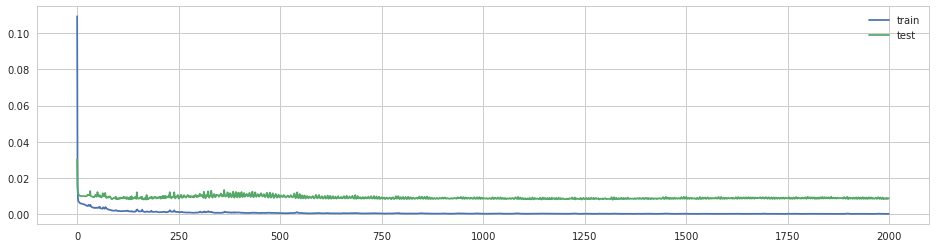

In [38]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
test_index = 0

In [40]:
main_result, aux_result = model.predict({'main_input':test_X[test_index:test_index+batch_size],\
                                         'aux_input':aux_test_X[test_index:test_index+batch_size]})

In [41]:
main_pred = pd.DataFrame(main_result,index=test_df.index[test_index:test_index+batch_size]).T
aux_pred = pd.DataFrame(aux_result,index=test_df.index[test_index:test_index+batch_size]).T

In [42]:
test_real = test_df.iloc[:,-out_seq:].copy()
test_real = test_real.T
test_real

DT,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00,...,2017-11-04 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-11 00:00:00,2017-11-12 00:00:00,2017-11-13 00:00:00,2017-11-14 00:00:00
t+0,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,...,0.003771,0.031427,0.067882,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706
t+1,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,...,0.031427,0.067882,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909
t+2,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,...,0.067882,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424
t+3,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,...,0.137649,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940
t+4,0.065368,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,...,0.076053,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941
t+5,0.036455,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,...,0.062854,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396
t+6,0.038969,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,...,0.111251,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681
t+7,0.056568,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,0.101194,...,0.030798,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681,0.049026
t+8,0.091766,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,0.101194,0.125079,...,0.075424,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681,0.049026,0.033941
t+9,0.607165,0.003143,0.018856,0.037084,0.032684,0.038341,0.096166,0.101194,0.125079,0.126336,...,0.147706,0.094909,0.075424,0.055940,0.033941,0.070396,0.076681,0.049026,0.033941,0.079195


In [43]:
test_real.loc[:,:] = test_real.apply(target_scaler.inverse_transform)
main_pred.loc[:,:] = main_pred.apply(target_scaler.inverse_transform)
aux_pred.loc[:,:] = aux_pred.apply(target_scaler.inverse_transform)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data ei

In [44]:
main_pred

DT,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00
0,166.411346,204.360306,101.076859,101.849884,152.135605,97.475983,129.098328,145.388702,144.496872,160.898758
1,255.392380,193.429871,90.684860,59.070503,89.887421,172.931381,199.585663,222.986801,153.078949,223.010559
2,196.066116,211.547791,127.639915,69.522713,139.652573,199.488525,188.676575,421.723083,149.325684,176.129944
3,134.995346,210.306335,170.183533,78.117386,133.447311,188.995758,284.526154,299.760864,110.186722,219.002823
4,139.387497,211.244614,173.649033,131.967773,148.412033,228.844055,230.290466,191.015549,126.701302,135.688950
5,135.022430,145.499680,142.913223,197.446579,346.929626,178.820099,137.918442,337.484680,104.648376,91.439430
6,134.785339,192.610153,134.830460,398.751709,196.555893,96.959351,125.696106,121.257149,94.560646,166.546280
7,150.641510,188.908997,200.855072,190.297836,101.791908,125.556267,127.572327,190.375946,185.822113,267.477234
8,151.624542,248.528595,184.917999,94.185188,142.637634,132.100204,171.739899,209.111908,220.178101,175.367691
9,352.294678,88.059402,62.531212,127.560104,215.162933,205.500290,273.635071,252.632339,183.405869,191.787811


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


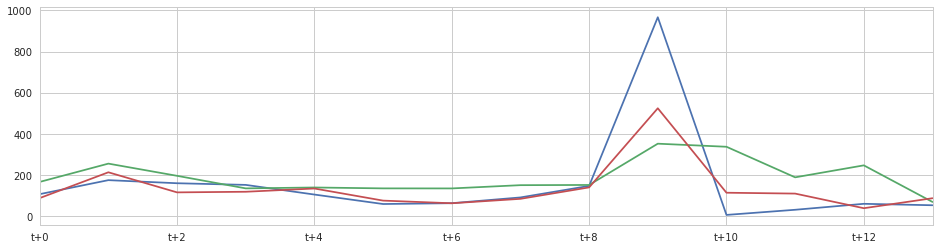

In [45]:
day = '2017-10-15 '
test_real[day].plot()
main_pred[day].plot()
aux_pred[day].plot()
# plt.plot(test_real.T)
# plt.plot(main_pred.T)
# plt.plot(aux_pred.T)

In [46]:
dataset.loc[day:].head(14).iloc[:,:11]

,BASE_QTY,INCM_QTY,END_QTY,MIN_ACTUAL_PAY,MED_ACTUAL_PAY,EVNT_11ST_2016,EVNT_MW_HOT_ISSUE,EVNT_MW_SHCK_DEAL,EVNT_MW_LOWER_BANS,EVNT_NOW_BANS,EVNT_OTHERS
DT,,,,,,,,,,,
2017-10-15,1489,0,1375,18140,18370,0,0,0,1,1,0
2017-10-16,1375,0,1211,17545,18370,0,0,0,1,1,0
2017-10-17,1211,0,1042,17545,18370,0,0,0,0,1,0
2017-10-18,1042,0,876,18140,18370,0,0,0,0,1,0
2017-10-19,876,0,757,18140,18370,0,0,0,0,1,0
2017-10-20,757,0,680,18140,18370,0,0,0,0,1,0
2017-10-21,680,0,680,18140,18370,0,0,0,0,1,0
2017-10-22,680,0,557,18140,18370,0,0,0,0,1,0
2017-10-23,557,640,1042,18140,18370,0,0,0,0,0,0


In [47]:
train_X.shape

(310, 14, 56)

In [48]:
aux_train_X.shape

(310, 120)

In [49]:
train_index = 20

In [50]:
train_main_result, train_aux_result = model.predict({'main_input':train_X[train_index:train_index+batch_size],\
                                                     'aux_input':aux_train_X[train_index:train_index+batch_size]})

In [51]:
train_main_pred = pd.DataFrame(train_main_result,index=train_df[train_index:train_index+batch_size].index).T
train_aux_pred = pd.DataFrame(train_aux_result,index=train_df[train_index:train_index+batch_size].index).T

In [52]:
train_real = train_df.iloc[:,-out_seq:].copy()
train_real = train_real.T
train_real

DT,2016-12-09 00:00:00,2016-12-10 00:00:00,2016-12-11 00:00:00,2016-12-12 00:00:00,2016-12-13 00:00:00,2016-12-14 00:00:00,2016-12-15 00:00:00,2016-12-16 00:00:00,2016-12-17 00:00:00,2016-12-18 00:00:00,...,2017-10-05 00:00:00,2017-10-06 00:00:00,2017-10-07 00:00:00,2017-10-08 00:00:00,2017-10-09 00:00:00,2017-10-10 00:00:00,2017-10-11 00:00:00,2017-10-12 00:00:00,2017-10-13 00:00:00,2017-10-14 00:00:00
t+0,0.160277,0.135135,0.362665,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,...,0.031427,0.077310,0.024513,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770
t+1,0.135135,0.362665,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,...,0.077310,0.024513,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625
t+2,0.362665,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,...,0.024513,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365
t+3,0.248272,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,...,0.020742,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937
t+4,0.159019,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,...,0.038341,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909
t+5,0.091138,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,...,0.040855,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368
t+6,0.104965,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,...,0.074167,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455
t+7,0.074796,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,0.010685,...,0.046512,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969
t+8,0.045883,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,0.010685,0.016970,...,0.054683,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568
t+9,0.015713,0.035827,0.097423,0.072282,0.030798,0.009428,0.006914,0.010685,0.016970,0.015713,...,0.025770,0.066625,0.109365,0.099937,0.094909,0.065368,0.036455,0.038969,0.056568,0.091766


In [53]:
train_real.loc[:,:] = train_real.apply(target_scaler.inverse_transform)
train_main_pred.loc[:,:] = train_main_pred.apply(target_scaler.inverse_transform)
train_aux_pred.loc[:,:] = train_aux_pred.apply(target_scaler.inverse_transform)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data ei

In [82]:
index = 7

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


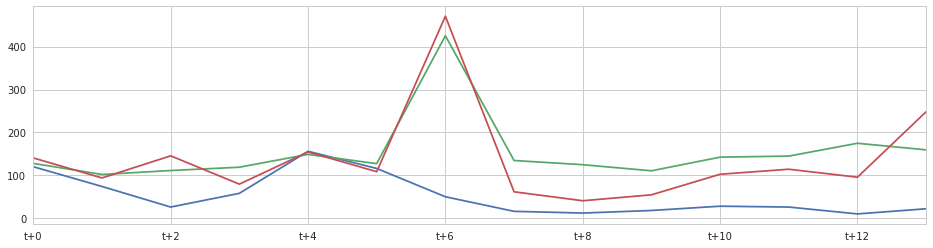

In [83]:
train_real.iloc[:,index].plot()
train_main_pred.iloc[:,index].plot()
train_aux_pred.iloc[:,index].plot()

# plt.plot(train_real.T)
# plt.plot(train_main_pred.T)
# plt.plot(train_aux_pred.T)

In [56]:
last_test = main_pred.T.tail(10)
last_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
DT,,,,,,,,,,,,,,
2017-10-15,166.411346,255.392380,196.066116,134.995346,139.387497,135.022430,134.785339,150.641510,151.624542,352.294678,337.341370,188.713745,246.954193,69.020721
2017-10-16,204.360306,193.429871,211.547791,210.306335,211.244614,145.499680,192.610153,188.908997,248.528595,88.059402,174.021683,155.520752,124.851906,94.190666
2017-10-17,101.076859,90.684860,127.639915,170.183533,173.649033,142.913223,134.830460,200.855072,184.917999,62.531212,85.426033,135.186005,136.544586,255.604843
2017-10-18,101.849884,59.070503,69.522713,78.117386,131.967773,197.446579,398.751709,190.297836,94.185188,127.560104,46.685303,59.212353,235.870911,139.834198
2017-10-19,152.135605,89.887421,139.652573,133.447311,148.412033,346.929626,196.555893,101.791908,142.637634,215.162933,134.933945,120.921593,159.893188,261.615845
2017-10-20,97.475983,172.931381,199.488525,188.995758,228.844055,178.820099,96.959351,125.556267,132.100204,205.500290,259.305084,254.584122,166.434006,58.783951
2017-10-21,129.098328,199.585663,188.676575,284.526154,230.290466,137.918442,125.696106,127.572327,171.739899,273.635071,296.075867,198.723770,127.144249,92.532700
2017-10-22,145.388702,222.986801,421.723083,299.760864,191.015549,337.484680,121.257149,190.375946,209.111908,252.632339,206.943649,167.396973,126.541206,100.683754
2017-10-23,144.496872,153.078949,149.325684,110.186722,126.701302,104.648376,94.560646,185.822113,220.178101,183.405869,136.551758,149.992218,89.731201,107.746132


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


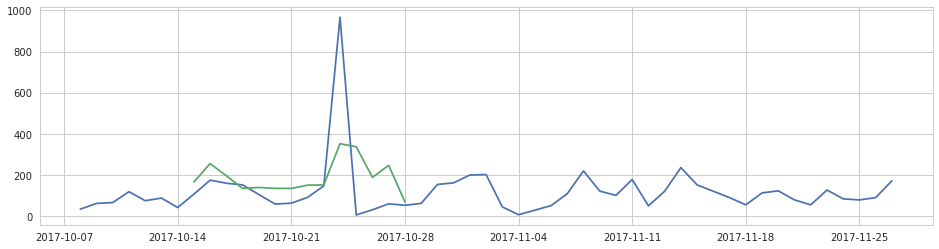

In [75]:
index = 10

last_test = main_pred.T.tail(index)
last_aux_test = aux_pred.T.tail(index)
last_test.columns = dataset.loc[last_test.index[0]:].head(14).index
last_aux_test.columns = dataset.loc[last_aux_test.index[0]:].head(14).index

plt.plot(dataset['target'].tail(50))
plt.plot(last_test.T.iloc[:,0])
#plt.plot(last_aux_test.T.iloc[:,0])

In [58]:
diff_value = pd.DataFrame(main_pred.values - test_real.values[:,:batch_size],columns=main_pred.columns)
diff_value

DT,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-21 00:00:00,2017-10-22 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00
0,59.411352,29.360304,-58.923145,-50.150117,47.135608,38.475980,66.098330,54.388700,-2.503130,-806.101198
1,80.392378,33.429868,-61.315141,-45.929493,30.887418,109.931384,108.585660,75.986799,-813.921007,217.010559
2,36.066113,59.547789,22.639919,10.522710,76.652575,108.488523,41.676573,-545.276872,143.325684,145.129944
3,-17.004655,105.306339,111.183530,15.117388,42.447309,41.995756,-682.473802,293.760864,79.186722,159.002822
4,34.387500,152.244611,110.649035,40.967771,1.412031,-738.155901,224.290466,160.015549,66.701300,82.688951
5,76.022428,82.499682,51.913220,50.446577,-620.070329,172.820099,106.918442,277.484679,51.648378,29.439432
6,71.785342,101.610150,-12.169542,-568.248247,190.555893,65.959351,65.696105,68.257150,32.560647,12.546281
7,59.641507,41.908995,-766.144884,184.297836,70.791908,65.556266,74.572328,128.375947,31.822114,105.477233
8,4.624540,-718.471361,178.917999,63.185188,82.637633,79.100206,109.739900,55.111909,58.178100,-24.632320
9,-614.705278,82.059403,31.531212,67.560103,162.162935,143.500291,119.635072,90.632339,-16.594142,-10.212185


In [59]:
diff_value.apply(np.square).sum().apply(lambda x: x/out_seq).apply(np.sqrt)

DT
2017-10-15    202.662271
2017-10-16    209.998936
2017-10-17    220.139149
2017-10-18    165.153034
2017-10-19    185.165124
2017-10-20    220.168047
2017-10-21    208.305775
2017-10-22    197.125653
2017-10-23    227.957921
2017-10-24    238.802641
dtype: float64

In [60]:
sum_rmse = np.abs(test_real.sum() - main_pred.sum())
sum_rmse 

DT
2017-10-15    482.651166
2017-10-16    312.080605
2017-10-17    107.956380
2017-10-18    181.627398
2017-10-19    183.977573
2017-10-20    108.779087
2017-10-21    340.215858
2017-10-22    806.302769
2017-10-23    190.574060
2017-10-24    226.251744
2017-10-25           NaN
2017-10-26           NaN
2017-10-27           NaN
2017-10-28           NaN
2017-10-29           NaN
2017-10-30           NaN
2017-10-31           NaN
2017-11-01           NaN
2017-11-02           NaN
2017-11-03           NaN
2017-11-04           NaN
2017-11-06           NaN
2017-11-07           NaN
2017-11-08           NaN
2017-11-09           NaN
2017-11-10           NaN
2017-11-11           NaN
2017-11-12           NaN
2017-11-13           NaN
2017-11-14           NaN
dtype: float64